In [37]:
# All Required libraries!!

def warn(*args, **kwargs):
    pass
import warnings # sub-class of Exception built-in class (warns the developer for situations)
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image # Python Imaging Library

# visualization librairies
import matplotlib.pyplot as plt
import matplotlib. image as mpimg
import seaborn as sns
%matplotlib inline

import os

from skimage import io, transform # image processing of scikit-learn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

# set up GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the parameters that control the scaling of plot elements.
sns.set_context('notebook')
sns.set_style('white')

In [38]:
#                                                       EXPLANATION AND SEMANTICS

# U2-Net : a two-level nested U-structure. Designed for saliency object detection or SOD (detecting the most important features in an image)

# Residual U-Block (RSU) mainly consists of three components:

# 1. An input convolution layer, which transforms the input feature map x (H×W ×C_in) to an intermediate map F1(x) with the channel of C_out. 

# 2. A U-Net-like symmetric encoder-decoder structure with a height of L 
#    that takes the intermediate feature map F1(x) as input and learns to extract and encode the multi-scale contextual information U(F1(x))

# 3. A residual connection that fuses local features and the multi-scale features by the summation: F1(x) +U(F1(x)).

In [39]:
def f(modules_dict, x):

    """
    This function takes in an OrderedDict (OrderedDict preserves the order in which the keys are inserted) that contains all the modules of a defined RSU block and an input x
    and returns a result of the forward passing of the modules
    
    """
    inner_enc_layers = []
    inner_dec_layers = []
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == 'd':
            inner_dec_layers.append(layer)
        else:
            inner_enc_layers.append(layer)

    hx = x
    hxin = inner_enc_layers[0](hx)
    hx = hxin
    inner_enc_outputs = []

    # inner block encode
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)

    # inner block decode + residual function
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(), inner_enc_outputs.pop()),1))
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_like(hxd, inner_enc_outputs[-1])
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()),1))

    return hxd + hxin

In [40]:
def normPRED(d):
    
    """
    This function normalizes a prediction
    
    """
    
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

In [41]:
# Tensor Data transformation classes

class RescaleT(object):
    def __init__(self, output_size):
        self.output_size = output_size
    
    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        img = transform.resize(image, (self.output_size, self.output_size), mode='constant')
        
        return {'imidx':imidx, 'image':img}

    
class ToTensor(object):
    def __init__(self, flag=0):
        self.flag = flag
    
    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        image = image/np.max(image)
        
        tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
        tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
        tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225
        
        tmpImg = tmpImg.transpose((2,0,1))
        
        return {'imidx':torch.from_numpy(imidx), 'image':torch.from_numpy(tmpImg)}

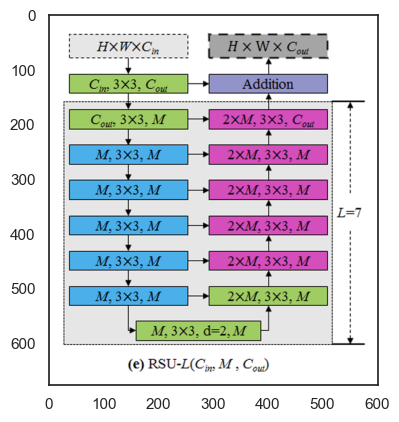

In [42]:
img_src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IND-GPXX0JV6EN/images/RSU.png"
image = mpimg.imread(img_src)   
imageplot = plt.imshow(image)
plt.show()


# The structure of RSU-L (C_in, M, C_out) . Here L is the number of layers in the encoder (or height), C_in, C_out denote input and output channels, 
# and M denotes the number of channels in the internal layers of RSU.                    

In [43]:
# Since an RSU consists of many Convolution + BatchNorm + Relu layers
# let's define a class that bundles the Convolution + BatchNorm + Relu activation together 

In [44]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()
        
        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate) 
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

        
    def forward(self, x):
        hx = x
        return self.relu_s1(self.bn_s1(self.conv_s1(hx)))

In [45]:
# define function for upsamples (it upsamples `src` so that `src` has the same shape as `tar`) (source ---> to archive)

def _upsample_like(src, tar):
    
    src = F.upsample(src, size=tar.shape[2:], mode='bilinear')
    return src

In [46]:
# TIME TO BUILD 5 RSU-L BLOCKS (EACH CONTAINING L Convolution + BatchNorm + Relu layers)

In [47]:
# An RSU-7 block has depth (L) of 7. It consists of:

# One input `REBNCONV` layer;

# Seven downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv6` and `rebnconv7` (to prevent the resolution of the last two layers being too low)

# Six upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU7(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [48]:
# An RSU-6 block has depth (L) of 6. It consists of:

# One input `REBNCONV` layer;

# Six downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv5` and `rebnconv6` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result
    

In [49]:
# An RSU-5 block has depth (L) of 5. It consists of:

# One input `REBNCONV` layer;

# Five downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv4` and `rebnconv5` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [50]:
# An RSU-4 block has depth (L) of 4. It consists of:

# One input `REBNCONV` layer;

# Four downsampling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv3` and `rebnconv4` (to prevent the resolution of the last two layers being too low)

# Five upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [51]:
# The RSU-4F block is slightly different from other RSU-L blocks. "F" means that the RSU is a dilated version,
# where we replace the pooling the upsampling operations with dilated convolutions. 
# This means all of intermediate feature maps of RSU-4F have the same resolution with its input feature maps.

# An RSU-4F block has depth (L) of 4. It consists of:

# One input `REBNCONV` layer;

# Four DILATED `REBNCONV` layers, each produces output of the same shape as the input.

# Three DILATED `REBNCONV` layers, each takes the concatenation of the feature maps from its previous layer and those from its symmetrical layer as input.



class RSU4F(nn.Module):
    
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [52]:
# SEE THE PARAMS (wieght and bias) FOR ANY RSU BLOCK

for name, param in RSU4().named_parameters():
    print(name)

rebnconvin.conv_s1.weight
rebnconvin.conv_s1.bias
rebnconvin.bn_s1.weight
rebnconvin.bn_s1.bias
rebnconv1.conv_s1.weight
rebnconv1.conv_s1.bias
rebnconv1.bn_s1.weight
rebnconv1.bn_s1.bias
rebnconv2.conv_s1.weight
rebnconv2.conv_s1.bias
rebnconv2.bn_s1.weight
rebnconv2.bn_s1.bias
rebnconv3.conv_s1.weight
rebnconv3.conv_s1.bias
rebnconv3.bn_s1.weight
rebnconv3.bn_s1.bias
rebnconv4.conv_s1.weight
rebnconv4.conv_s1.bias
rebnconv4.bn_s1.weight
rebnconv4.bn_s1.bias
rebnconv3d.conv_s1.weight
rebnconv3d.conv_s1.bias
rebnconv3d.bn_s1.weight
rebnconv3d.bn_s1.bias
rebnconv2d.conv_s1.weight
rebnconv2d.conv_s1.bias
rebnconv2d.bn_s1.weight
rebnconv2d.bn_s1.bias
rebnconv1d.conv_s1.weight
rebnconv1d.conv_s1.bias
rebnconv1d.bn_s1.weight
rebnconv1d.bn_s1.bias


In [53]:
# TIME FOR THE U2-NET ARCHITECTURE

# Using all the RSU-L blocks and the RSU-4F block we created previously, the U2-Net mainly consists of three parts:

# A six stages encoder composed of RSU-7, RSU-6, RSU-5, RSU-4, RSU-4F, and RSU-4F

# A five stages decoder composed of RSU-4F, RSU-4, RSU-5, RSU-6, and RSU-7

# A saliency map fusion module attached with the decoder stages and the last encoder stage for generating side output saliency probability maps
# ---> they will be fused to produce the final saliency probability map.

# !!!!!!
# Each decoder stage takes the concatenation of the decoded feature maps from its previous stage and those from its symmetrical encoder stage as the input.
# !!!!!!

In [54]:
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        # encoder
        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        #side 
        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)
        
        
    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0) #, F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [ ]:
# Lest build our model

model = U2NET(3, 1)
model.to(device) 

In [68]:
# LOAD PRETRAINED PARAMETERS TO THE MODEL 

model.load_state_dict(torch.load("pretrained_u2net/u2net.pth", map_location=device))


<All keys matched successfully>